In [1]:
import pandas as pd, numpy as np
np.set_printoptions(suppress=True)# 关掉科学计数法
import glob
import os
import csv
# 一次性merge多个pct_chg
from functools import reduce
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels import regression

import tushare as ts
import time, urllib
ts.set_token('8ef5ec61cdd848715c57c11d58dd71da1271f76b2420d2bac8aef123')
pro = ts.pro_api('8ef5ec61cdd848715c57c11d58dd71da1271f76b2420d2bac8aef123')

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)


from plotly.graph_objs import Scatter,Layout
import plotly
import plotly.offline as py
import numpy as np
import plotly.graph_objs as go

#setting offilne
plotly.offline.init_notebook_mode(connected=True)

# Functions

- signal_generators: merge market data with technical analysis signals
- position calculators: calculate position based on a variety of principles (money-hedge/beta-hedge/risk-parity)
- ticker filters:
- backtester

# TechnicalIndicators

In [2]:
class TechnicalIndicators(object):

    def EMA(df, n, price_col): # n = 5
        """
        Exponential Moving Average
        rationale CHECKED, code CHECKED, updated.

        params:
            df: pd dataframe
            n: number of days = 5
        """
        EMA = df[price_col].ewm(span=n, min_periods=n - 1).mean().rename('EMA_' + str(n))
        return EMA

    def OBV(df, n, price_col, vol_col): # n = 5
        """On-balance Volume

        On Balance Volume (OBV) measures buying and selling pressure as a cumulative indicator that adds 
        volume on up days and subtracts volume on down days. OBV was developed by Joe Granville and introduced 
        in his 1963 book, Granville's New Key to Stock Market Profits. It was one of the first indicators to 
        measure positive and negative volume flow. Chartists can look for divergences between OBV and price 
        to predict price movements or use OBV to confirm price trends.

        http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:on_balance_volume_obv
        """
        df = df.reset_index()
        i = 0
        OBV = [0]
        while i < df.index[-1]:
            if df.at[i + 1, price_col] - df.at[i, price_col] > 0:
                OBV.append(df.at[i + 1, vol_col])
            if df.at[i + 1, price_col] - df.at[i, price_col] == 0:
                OBV.append(0)
            if df.at[i + 1, price_col] - df.at[i, price_col] < 0:
                OBV.append(-df.at[i + 1, vol_col])
            i = i + 1
        OBV = pd.Series(OBV)
        OBV_ma = pd.Series(OBV.rolling(window=n).mean(), name = 'OBV_' + str(n))
        return OBV_ma

    # Rationale checked
    def MFI(df, n, hi_col, lo_col, price_col, vol_col): # n = 14
        """Money Flow Index and Ratio, updated.
        http://stockcharts.com/docs/doku.php?id=scans:indicators#money_flow_index_mfi

        """
        df = df.reset_index()
        PP = (df[hi_col] + df[lo_col] + df[price_col]) / 3
        i  = 0
        PosMF = [0]
        while i < df.index[-1]:
            if PP[i + 1] > PP[i]:
                PosMF.append(PP[i + 1] * df.at[i + 1, vol_col])
            else:
                PosMF.append(0)
            i = i + 1
        PosMF = pd.Series(PosMF)
        TotMF = PP * df[vol_col]
        MFR   = pd.Series(PosMF / TotMF)
        MFI   = pd.Series(MFR.rolling(window = n, center = False).mean(), name = 'MFI_' + str(n))
        df    = df.join(MFI).set_index("index")
        return df["MFI_" + str(n)]

    # Done
    # Rationale checked
    def RSI(df, n, hi_col, lo_col): # n = 14
        """
        Relative Strength Index, updated.
        Conventional parameters: n = 14, 0.3 and 0.7 are two conventional thresholds
        """
        df = df.reset_index()
        i = 0
        UpI = [0]
        DoI = [0]
        while i + 1 <= df.index[-1]:
            UpMove = df.at[i + 1, hi_col] - df.at[i, hi_col]
            DoMove = df.at[i, lo_col] - df.at[i + 1, lo_col]
            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else: UpD = 0
            UpI.append(UpD)
            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else: DoD = 0
            DoI.append(DoD)
            i = i + 1
        UpI   = pd.Series(UpI)
        DoI   = pd.Series(DoI)
        PosDI = UpI.ewm(span = n, min_periods = n - 1).mean()
        NegDI = DoI.ewm(span = n, min_periods = n - 1).mean()
        RSI   = pd.Series(PosDI / (PosDI + NegDI), name = 'RSI_' + str(n))
        df    = df.join(RSI).set_index("index")
        return df["RSI_" + str(n)]

    def BIAS(df, n, price_col):
        BIAS = df[price_col]-df[price_col].rolling(window=n).mean().rename('BIAS_'+str(n))
        return BIAS

    def MACD(df, n_fast, n_slow, n_macd, price_col): # n_fast = 12, n_slow = 26
        """
        http://stockcharts.com/docs/doku.php?id=scans:indicators
        MACD, MACD Signal and MACD difference, rationale CHECKED, code CHECKED, updated
        # Conventional look-back window for calculating MACDsign is 9
        """
        EMAfast = df[price_col].ewm(span = n_fast, min_periods = n_fast - 1).mean()
        EMAslow = df[price_col].ewm(span = n_slow, min_periods = n_slow - 1).mean()
        MACD = pd.Series(EMAfast - EMAslow, name = 'MACD_' + str(n_fast) + '_' + str(n_slow))
        MACDsign = MACD.ewm(span = n_macd, min_periods = n_macd-1).mean().rename('MACDsign_' + str(n_fast) + '_' + str(n_slow))
        MACDdiff = pd.Series(MACD - MACDsign, name = 'MACDdiff_' + str(n_fast) + '_' + str(n_slow))
        df['MACD_Diff'] = MACD
        df['MACD_Diff_EMA'] = MACDsign
        df['MACD'] = MACDdiff
        df['SIGNAL_STATUS'] = df['MACD'].apply(lambda x: "多头状态" if x>0 else ("空头状态" if x<0 else "无信号状态"))
        return df

# TimeSeriesToolbox

In [3]:
class GetData(object):
    
    def get_date_price_code_df(path, ticker_list, date_col, price_col, code_col):
        # for etf data cols are 'date', 'close', 'code'
        ticker_df_list = []
#         print(ticker_list)
        for ticker in ticker_list:
            print(ticker)
            try:
#                 print("get thru")
                
                ticker_df = pd.read_csv(path+ticker+".csv")
                ticker_df[code_col] = ticker_df[code_col].astype(str)
                ticker_df = ticker_df.sort_values(date_col)
                ticker_df = ticker_df[[date_col, price_col, code_col]]
#                 print(ticker_df)
                ticker_df_list.append(ticker_df)
            except Exception as e:
                print(e)
        try:
            tickers_data_concated = pd.concat(ticker_df_list)
            tickers_data_concated.reset_index(inplace=True)
            del tickers_data_concated['index']  
        except Exception as e:
            print(e)
#         print(tickers_data_concated)
        return tickers_data_concated

In [4]:
class TimeSeriesToolbox(object):
        
    def make_numeric_signals(series):
        for item in series:
            if item =="多":
                return 1
            elif item =="空":
                return -1
            else:
                return 0 
            
    def merge_weights_and_signal(df_actions,
                                 df_wts,
                                 path,
                                 code_col,
                                 date_col,
                                 price_col,
                                 tgt_wts_mutiplier,
                                 account_value):
        if df_actions.empty:
            print("There's no data in df_actions. No actional signals for today!")
            pass
            
        else:
            # 合并仓位数据和信号数据
            df_actions_with_weights = df_wts.merge(df_actions, on =code_col)

            # 仓位太小，创建2倍仓位信息, e.g. tgt_wts_mutiplier = 2
            df_actions_with_weights['weight_enlarged'] = df_actions_with_weights['weight']*tgt_wts_mutiplier
    #         print(df_actions_with_weights)
            # 提取下一日要操作的tickers
            tickers = list(df_actions_with_weights[code_col])
    #         print(tickers)
            # 得到这些tickers的收盘价数据
    #         print(tickers)
            tickers_closes = GetData.get_date_price_code_df(path,
                                                             tickers,
                                                             date_col, 
                                                             price_col, 
                                                             code_col)
    #         print(tickers_closes)
            # 创建今日date信息
            last_date = tickers_closes[date_col].values[-1]
    #         print(last_date)
            # 提取最近一天的tickers的收盘价数据
            tickers_closes_last_date = tickers_closes[tickers_closes[date_col] == last_date]

            # 创建最终的信号-仓位指示信息
            df_actions_with_weights = df_actions_with_weights.merge(tickers_closes_last_date, on = [date_col,
                                                                                                    code_col])
            df_actions_with_weights['tgt_shares'] = account_value*\
                                                    df_actions_with_weights['weight_enlarged']/\
                                                    df_actions_with_weights[price_col]
            return df_actions_with_weights
    

# PlotToolbox

In [5]:
class PlotToolbox(object):
    
    def pie_graph(values, labels, pie_length, pie_width, title_name):
        # draw pie graph
        plt.figure(1, figsize = (pie_length, pie_width))
        plt.axes(aspect=1)
        plt.pie(x=values, labels=labels, autopct='%3.1f %%')
        plt.title(title_name, fontsize = 15)
        plt.show()

In [6]:
# 在分析环境里，筛选出tickers，然后使用MACD_signals

class MACDSignals(object):
    
    def __init__(self, stocks_path, tickers, date_col, code_col, price_col, n_fast, n_slow, n_macd, ticker_type):
        self.path = stocks_path
        self.tickers = tickers
        self.date_col = date_col
        self.code_col = code_col
        self.price_col = price_col
        self.n_fast = n_fast
        self.n_slow = n_slow
        self.n_macd = n_macd
        self.ticker_type = ticker_type
        self.mkt_data = self.get_mkt_data_df()

    def get_mkt_data_df(self):
    # e.g. ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
        csv_path = self.path+"*.csv"
        files = glob.glob(csv_path)
        ticker_df_list = []
        for ticker in tickers:
            try:
                ticker_df = pd.read_csv(self.path+ticker+".csv")
                ticker_df[self.code_col] = ticker_df[self.code_col].astype(str)
                ticker_df = ticker_df.sort_values(self.date_col)
                ticker_df_list.append(ticker_df)
            except Exception as e:
                print(e)
        try:
            tickers_data_concated = pd.concat(ticker_df_list)
            tickers_data_concated.reset_index(inplace=True)
            del tickers_data_concated['index']  
        except Exception as e:
            print(e)
        return tickers_data_concated
    

    def calc_macd_signals(self):
        tickers_data_concated = self.mkt_data
#         print(tickers_data_concated)
        signal_record = []
        signal_data = []
        if len(self.tickers)!=1:
            for ticker in self.tickers:
                try:
                    if self.ticker_type == "float":
                        single_ticker_df = tickers_data_concated[tickers_data_concated[self.code_col]==float(ticker)]
                    elif self.ticker_type == "string":
                        single_ticker_df = tickers_data_concated[tickers_data_concated[self.code_col]==ticker]
                        
                    signal_df = TechnicalIndicators.MACD(single_ticker_df, self.n_fast, self.n_slow, self.n_macd, self.price_col)
                    
                    signal_data.append(signal_df)
                except:
                    pass
            signal_data_df = pd.concat(signal_data)
        else:
            try:                
                signal_df = TechnicalIndicators.MACD(single_ticker_df, self.n_fast, self.n_slow, self.n_macd, self.price_col)
            except:
                pass
            signal_data_df = signal_df

        # v1 is the version of generating the og macd signals
        signal_data_df['SIGNAL_DIRECTION'] = signal_data_df['SIGNAL_STATUS'].apply(lambda x: TimeSeriesToolbox.make_numeric_signals(x))
        signal_data_df['SIGNAL_DIRECTION_DIFF'] = signal_data_df.groupby([self.code_col])['SIGNAL_DIRECTION'].diff()
        signal_data_df['SIGNAL_ACTION'] = signal_data_df['SIGNAL_DIRECTION_DIFF'].apply(lambda x: "LONG" if x==2 else("SHORT" if x==-2 else "NO CHANGE"))
#         print(signal_data_df)
        most_recent_signals = signal_data_df.groupby([self.code_col])[[self.date_col,self.code_col,'SIGNAL_STATUS','SIGNAL_ACTION']].tail(1)
        df_actions = most_recent_signals[most_recent_signals["SIGNAL_ACTION"]!="NO CHANGE"]
        return signal_data_df, most_recent_signals, df_actions

In [7]:
from scipy.optimize import minimize

class RiskParity(object):
    
    def __init__(self, stocks_path, tickers, 
                 date_col, code_col, price_col, 
                 ticker_type, asset_name, draw_pie_graph):
        
        self.path = stocks_path
        self.tickers = tickers
        self.date_col = date_col
        self.code_col = code_col
        self.price_col = price_col
        self.ticker_type = ticker_type
        self.asset_name = asset_name
        self.draw_pie_graph = draw_pie_graph
        self.ticker_df_list = self.get_date_price_code_return_list()
        self.tgt_returns = self.ticker_df_list
        self.tgt_merged_returns = self.merge_dfs_by_ticker(self.tgt_returns, 
                                                           self.date_col)
        self.wts, self.risk = self.get_smart_weight(self.tgt_merged_returns, 
                                                    method='risk parity', 
                                                    cov_adjusted=False, 
                                                    wts_adjusted=False)
        self.df_wts, self.risk_parity_tickers, self.weights = self.get_df_wts()
        
        
    # Get date_col, price_col, code_col, pct_chg_col
    def get_date_price_code_return_list(self):
        # for etf data cols are 'date', 'close', 'code'
        ticker_df_list = []
        for ticker in self.tickers:
            try:
                ticker_df = pd.read_csv(self.path+ticker+".csv")
                ticker_df = ticker_df.sort_values(self.date_col)
                ticker_df = ticker_df[[self.date_col, 
                                       self.price_col, 
                                       self.code_col]]
                ticker_df['pct_chg'] = ticker_df[self.price_col].pct_change()
                ticker_df = ticker_df[[self.date_col, 'pct_chg']].dropna()
                ticker_df.columns = [self.date_col, ticker]
                ticker_df_list.append(ticker_df)
            except Exception as e:
                print(e)
        return ticker_df_list
    
    
    def merge_dfs_by_ticker(self, ticker_df_list, date_col):
        merged_all = reduce(lambda left, right: pd.merge(left, right, on=date_col), ticker_df_list)
#         merged_all = reduce(merge_df_for_reduce, ticker_df_list)
        merged_all.set_index(self.date_col, inplace=True)
        merged_all.dropna(how="all", axis = 1, inplace = True)
        merged_all.fillna(method="ffill", inplace = True)
        return merged_all
        
        
    def get_smart_weight(self, pct, method='risk parity', cov_adjusted=False, wts_adjusted=False):
        if cov_adjusted == False:
            #协方差矩阵
            cov_mat = pct.cov()
        else:
            #调整后的半衰协方差矩阵
            cov_mat = pct.iloc[:len(pct)/4].cov()*(1/10.) + pct.iloc[len(pct)/4+1:len(pct)/2].cov()*(2/10.) +\
                pct.iloc[len(pct)/2+1:len(pct)/4*3].cov()*(3/10.) + pct.iloc[len(pct)/4*3+1:].cov()*(4/10.)
        if not isinstance(cov_mat, pd.DataFrame):
            raise ValueError('cov_mat should be pandas DataFrame！')

        omega = np.matrix(cov_mat.values)  # 协方差矩阵

        a, b = np.linalg.eig(np.array(cov_mat)) #a为特征值,b为特征向量
        a = np.matrix(a)
        b = np.matrix(b)
        # 定义目标函数
    
        def fun1(x):
            tmp = (omega * np.matrix(x).T).A1
            risk = x * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
            delta_risk = [sum((i - risk)**2) for i in risk]
            return sum(delta_risk)

        def fun2(x):
            tmp = (b**(-1) * omega * np.matrix(x).T).A1
            risk = (b**(-1)*np.matrix(x).T).A1 * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
            delta_risk = [sum((i - risk)**2) for i in risk]
            return sum(delta_risk)
    
        # 初始值 + 约束条件 
        x0 = np.ones(omega.shape[0]) / omega.shape[0]  
        bnds = tuple((0,None) for x in x0)
        cons = ({'type':'eq', 'fun': lambda x: sum(x) - 1})
        options={'disp':False, 'maxiter':1000, 'ftol':1e-20}

        if method == 'risk parity':
            res = minimize(fun1, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
        elif method == 'pc risk parity':
            res = minimize(fun2, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
        else:
            raise ValueError('method error！！！')

        # 权重调整
        if res['success'] == False:
            # print res['message']
            pass
        wts = pd.Series(index=cov_mat.index, data=res['x'])

        if wts_adjusted == True:
            wts[wts < 0.0001]=0.0
            wts = wts / wts.sum()
        elif wts_adjusted == False:
            wts = wts / wts.sum()
        else:
            raise ValueError('wts_adjusted should be True/False！')

        risk = pd.Series(wts * (omega * np.matrix(wts).T).A1 / np.sqrt(np.matrix(wts) * omega * np.matrix(wts).T).A1[0],index = cov_mat.index)
        risk[risk<0.0] = 0.0
        return wts,risk
    
        
    def get_df_wts(self):
        df_wts = pd.DataFrame(self.wts)
        df_wts.reset_index(inplace = True)
        df_wts.columns = [self.asset_name, 'weight']
        risk_parity_tickers = list(df_wts[self.asset_name])
        weights = list(df_wts['weight'])
        return df_wts, risk_parity_tickers, weights


In [8]:
if __name__=="__main__":
    stocks_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
    leaders_tickers_df = pd.read_csv("20200309_110_A_shares_industry_leaders.csv")
    leaders_tickers = list(leaders_tickers_df['tickers'])
    tickers = leaders_tickers
    date_col = 'trade_date'
    code_col = 'ts_code'
    price_col = 'close'
    ticker_type = 'string'
    asset_name = "ts_code"
#     # ========For calculating MACD signals========
    n_fast = 12
    n_slow = 26
    n_macd = 9
    macd = MACDSignals(stocks_path, 
                        tickers, 
                        date_col, 
                        code_col, 
                        price_col, 
                        n_fast, 
                        n_slow, 
                        n_macd, 
                        ticker_type)
    macd_signals, last_macd_signals, df_actions = macd.calc_macd_signals()
    # ========For calculating risk-parity weights========
    risk_parity = RiskParity(stocks_path,
                              tickers,
                              date_col,
                              code_col,
                              price_col,
                              ticker_type,
                              asset_name,
                              True)
    df_wts, risk_parity_tickers, weights = risk_parity.get_df_wts()
    df_actions_with_weights = TimeSeriesToolbox.merge_weights_and_signal(df_actions,
                                                                     df_wts,
                                                                     stocks_path,
                                                                     code_col,
                                                                     date_col,
                                                                     price_col,
                                                                     2,
                                                                     70000)
#     PlotToolbox.pie_graph(weights, risk_parity_tickers, 8, 8, "Risk Parity Allocation")

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/pandas/compat/_optional.py:106: UserWarning:

Pandas requires version '2.6.2' or newer of 'numexpr' (version '2.6.1' currently installed).

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:110: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipyk

600555.SH


In [19]:
last_macd_signals

,date,code,SIGNAL_STATUS,SIGNAL_ACTION
1618,2020-03-19,518880,空头状态,NO CHANGE
3123,2020-03-19,513500,空头状态,NO CHANGE
4792,2020-03-19,513100,空头状态,NO CHANGE
6595,2020-03-19,159920,空头状态,NO CHANGE
8300,2020-03-19,510500,空头状态,NO CHANGE
9070,2020-03-19,513050,空头状态,NO CHANGE
11549,2020-03-19,510180,空头状态,NO CHANGE
13351,2020-03-19,510900,空头状态,NO CHANGE
15830,2020-03-19,159901,空头状态,NO CHANGE
16035,2020-03-19,512290,空头状态,NO CHANGE


In [10]:
# When there's no actions to be made, there's an error reported that says 
last_macd_signals[last_macd_signals['SIGNAL_ACTION']!="NO CHANGE"]

,trade_date,ts_code,SIGNAL_STATUS,SIGNAL_ACTION
226717,2020-03-20,600555.SH,空头状态,SHORT


In [11]:
long_short_counts = macd_signals.groupby(['trade_date','SIGNAL_DIRECTION'])['ts_code'].count()
long_short_counts_df = pd.DataFrame(long_short_counts)
long_short_counts_df.reset_index(inplace=True)

long_counts_df = long_short_counts_df[long_short_counts_df['SIGNAL_DIRECTION']==1]
short_counts_df = long_short_counts_df[long_short_counts_df['SIGNAL_DIRECTION']==-1]
long_short_counts_df_merged = long_counts_df.merge(short_counts_df, on = 'trade_date')
long_short_counts_df_merged['long_short_ratio'] = long_short_counts_df_merged['ts_code_x']/(\
                                                                                            long_short_counts_df_merged['ts_code_x']+\
                                                                                            long_short_counts_df_merged['ts_code_y'])
long_short_counts_df_merged.index = pd.to_datetime(long_short_counts_df_merged['trade_date'])

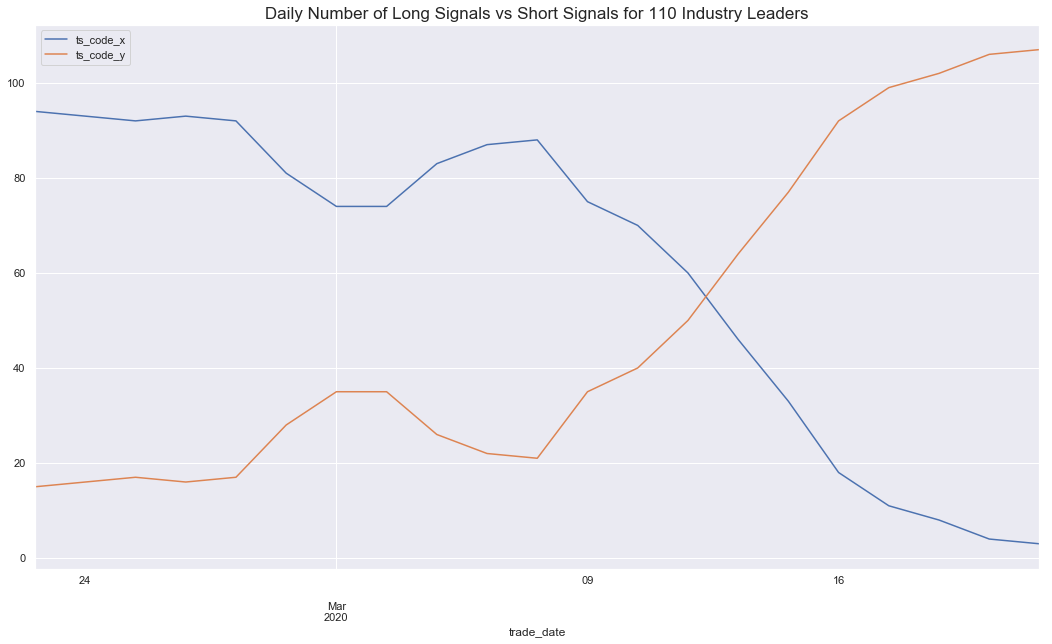

In [12]:
long_short_counts_df_merged[['ts_code_x','ts_code_y']].tail(21).plot(figsize = (18,10));
plt.title("Daily Number of Long Signals vs Short Signals for 110 Industry Leaders", fontsize = 17);

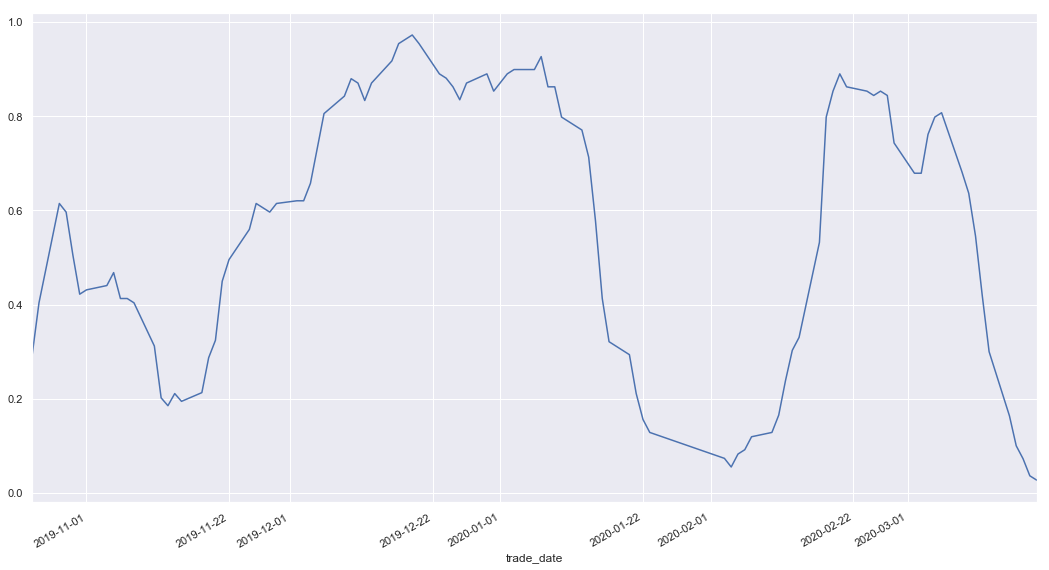

In [13]:
long_short_counts_df_merged['long_short_ratio'].tail(100).plot(figsize = (18,10))

In [14]:
long_short_counts_df_merged

,trade_date,SIGNAL_DIRECTION_x,ts_code_x,SIGNAL_DIRECTION_y,ts_code_y,long_short_ratio
trade_date,,,,,,
2010-02-23,2010-02-23,1,44,-1,7,0.862745
2010-02-24,2010-02-24,1,60,-1,5,0.923077
2010-02-25,2010-02-25,1,66,-1,3,0.956522
2010-02-26,2010-02-26,1,68,-1,1,0.985507
2010-03-01,2010-03-01,1,70,-1,1,0.985915
...,...,...,...,...,...,...
2020-03-16,2020-03-16,1,18,-1,92,0.163636
2020-03-17,2020-03-17,1,11,-1,99,0.100000
2020-03-18,2020-03-18,1,8,-1,102,0.072727


In [15]:
macd_signals

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,MACD_Diff,MACD_Diff_EMA,MACD,SIGNAL_STATUS,SIGNAL_DIRECTION,SIGNAL_DIRECTION_DIFF,SIGNAL_ACTION
0,000063.SZ,2010-01-04,19.5287,19.7281,19.1688,19.6847,19.4549,0.2298,1.1812,117213.58,528042.3546,NaN,NaN,NaN,无信号状态,0,NaN,NO CHANGE
1,000063.SZ,2010-01-05,19.7151,20.2397,19.4810,20.0533,19.6847,0.3686,1.8725,147432.25,678664.5218,NaN,NaN,NaN,无信号状态,0,0.0,NO CHANGE
2,000063.SZ,2010-01-06,20.0750,20.1964,19.5980,19.6414,20.0533,-0.4119,-2.0540,104292.59,477835.1887,NaN,NaN,NaN,无信号状态,0,0.0,NO CHANGE
3,000063.SZ,2010-01-07,19.6024,19.6154,18.5271,18.7352,19.6414,-0.9062,-4.6137,186837.08,815641.6630,NaN,NaN,NaN,无信号状态,0,0.0,NO CHANGE
4,000063.SZ,2010-01-08,18.7309,19.0691,18.4317,18.8132,18.7352,0.0780,0.4163,137477.32,592013.8023,NaN,NaN,NaN,无信号状态,0,0.0,NO CHANGE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233725,600084.SH,2020-03-16,2.5000,2.5200,2.4000,2.4100,2.4900,-0.0800,-3.2129,87040.00,21509.6130,0.005085,0.003339,0.001746,多头状态,1,0.0,NO CHANGE
233726,600084.SH,2020-03-17,2.4200,2.4500,2.3100,2.3800,2.4100,-0.0300,-1.2448,84668.04,19966.8450,-0.004609,0.001750,-0.006358,空头状态,-1,-2.0,SHORT
233727,600084.SH,2020-03-18,2.4000,2.4200,2.3000,2.3100,2.3800,-0.0700,-2.9412,73456.00,17309.6140,-0.017735,-0.002147,-0.015588,空头状态,-1,0.0,NO CHANGE
233728,600084.SH,2020-03-19,2.3000,2.3100,2.2500,2.2900,2.3100,-0.0200,-0.8658,65893.14,15086.8600,-0.029413,-0.007600,-0.021812,空头状态,-1,0.0,NO CHANGE


In [16]:
if __name__=="__main__":
    stocks_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
    etfs_df = pd.read_csv("filtered_50_etfs_by_vol_20200224.csv")
    tickers = list(etfs_df['etf'].str.split(".",expand = True)[0])
#     date_col = 'trade_date'
#     code_col = 'ts_code'
#     price_col = 'close'
    date_col = 'date'
    code_col = 'code'
    price_col = 'close'
    ticker_type = 'string'
    asset_name = "code"

    
#     # ========For calculating MACD signals========
    n_fast = 12
    n_slow = 26
    n_macd = 9
    macd = MACDSignals(stocks_path, 
                        tickers, 
                        date_col, 
                        code_col, 
                        price_col, 
                        n_fast, 
                        n_slow, 
                        n_macd, 
                        ticker_type)
    macd_signals, last_macd_signals, df_actions = macd.calc_macd_signals()

    # ========For calculating risk-parity weights========
    risk_parity = RiskParity(stocks_path,
                              tickers,
                              date_col,
                              code_col,
                              price_col,
                              ticker_type,
                              asset_name,
                              True)
    
    df_wts, risk_parity_tickers, weights = risk_parity.get_df_wts()
    
    df_actions_with_weights = TimeSeriesToolbox.merge_weights_and_signal(df_actions,
                                                                     df_wts,
                                                                     stocks_path,
                                                                     code_col,
                                                                     date_col,
                                                                     price_col,
                                                                     2,
                                                                     70000)
#     PlotToolbox.pie_graph(weights, risk_parity_tickers, 8, 8, "Risk Parity Allocation")

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:110: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

There's no data in df_actions. No actional signals for today!


In [18]:
df_actions_with_weights

In [17]:
# 在分析环境里，筛选出tickers，然后使用MACD_signals

class BIAS_signals(object):
    
    def __init__(self, stocks_path, tickers, date_col, code_col, price_col, n_fast, n_slow, n_macd, ticker_type):
        self.path = stocks_path
        self.tickers = tickers
        self.date_col = date_col
        self.code_col = code_col
        self.price_col = price_col
        self.ticker_type = ticker_type
    

    def get_mkt_data_df(self):
    # e.g. ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
        print(self.path)
        csv_path = self.path+"*.csv"
        files = glob.glob(csv_path)
        ticker_df_list = []
        for ticker in self.tickers:
            try:
                ticker_df = pd.read_csv(self.path+ticker+".csv")
                ticker_df = ticker_df.sort_values(self.date_col)
                ticker_df_list.append(ticker_df)
            except Exception as e:
                print(e)
        try:
            tickers_data_concated = pd.concat(ticker_df_list)
            tickers_data_concated.reset_index(inplace=True)
            del tickers_data_concated['index']  
        except Exception as e:
            print(e)
        return tickers_data_concated
    

    def calc_macd_signals(self):
        tickers_data_concated = get_mkt_data_df(self.path, self.tickers, self.date_col)
        signal_record = []
        signal_data = []
        if len(self.tickers)!=1:
            for ticker in self.tickers:
                try:
                    if self.ticker_type == "float":
                        single_ticker_df = tickers_data_concated[tickers_data_concated[self.code_col]==float(ticker)]
                    elif self.ticker_type == "string":
                        single_ticker_df = tickers_data_concated[tickers_data_concated[self.code_col]==ticker]
                        
                    signal_df = MACD(single_ticker_df, self.n_fast, self.n_slow, self.n_macd, self.price_col)# 这个地方出错了
                    signal_data.append(signal_df)
                except:
                    pass
            signal_data_df = pd.concat(signal_data)
        else:
            try:                
                signal_df = MACD(single_ticker_df, self.n_fast, self.n_slow, self.n_macd, self.price_col)
            except:
                pass
            signal_data_df = signal_df

        # v1 is the version of generating the og macd signals
        signal_data_df['SIGNAL_DIRECTION'] = signal_data_df['SIGNAL_STATUS'].apply(lambda x: make_numeric_signals(x))
        signal_data_df['SIGNAL_DIRECTION_DIFF'] = signal_data_df.groupby([self.code_col])['SIGNAL_DIRECTION'].diff()
        signal_data_df['SIGNAL_ACTION'] = signal_data_df['SIGNAL_DIRECTION_DIFF'].apply(lambda x: "LONG" if x==2 else("SHORT" if x==-2 else "NO CHANGE"))
        most_recent_signals = signal_data_df.groupby([self.code_col])[[self.date_col,self.code_col,'SIGNAL_STATUS','SIGNAL_ACTION']].tail(1)
        return signal_data_df, most_recent_signals
    